In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pathlib
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
import cv2

dataset_path = "../datasets/Wound_dataset"
print(dataset_path)

for d in dataset_path:
  print(d)

for root, dirs, files in os.walk(dataset_path):
  # print("Directory: ", root)
  for filename in files:
    full_filepath = os.path.join(root, filename)
    # print(f" = {full_filepath}")

../datasets/Wound_dataset
.
.
/
d
a
t
a
s
e
t
s
/
W
o
u
n
d
_
d
a
t
a
s
e
t


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## image mode = RGB -> 3 channels

In [3]:
def preprocess(img):
  if img.shape[2] == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224, 224))
  img = img.astype("float32")

  img = preprocess_input(img)
  img = np.expand_dims(img, axis=0)
  return img

In [4]:
BATCH_SIZE = 32
IMG_WIDTH = 180
IMG_HEIGHT = 180

In [5]:
train_set = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 431 files belonging to 7 classes.
Using 345 files for training.


In [6]:
validation_set = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_HEIGHT),
    batch_size=BATCH_SIZE
)

Found 431 files belonging to 7 classes.
Using 86 files for validation.


In [7]:
class_names = train_set.class_names
print(class_names)

['Abrasions', 'Bruises', 'Burns', 'Cut', 'Ingrown_nails', 'Laceration', 'Stab_wound']


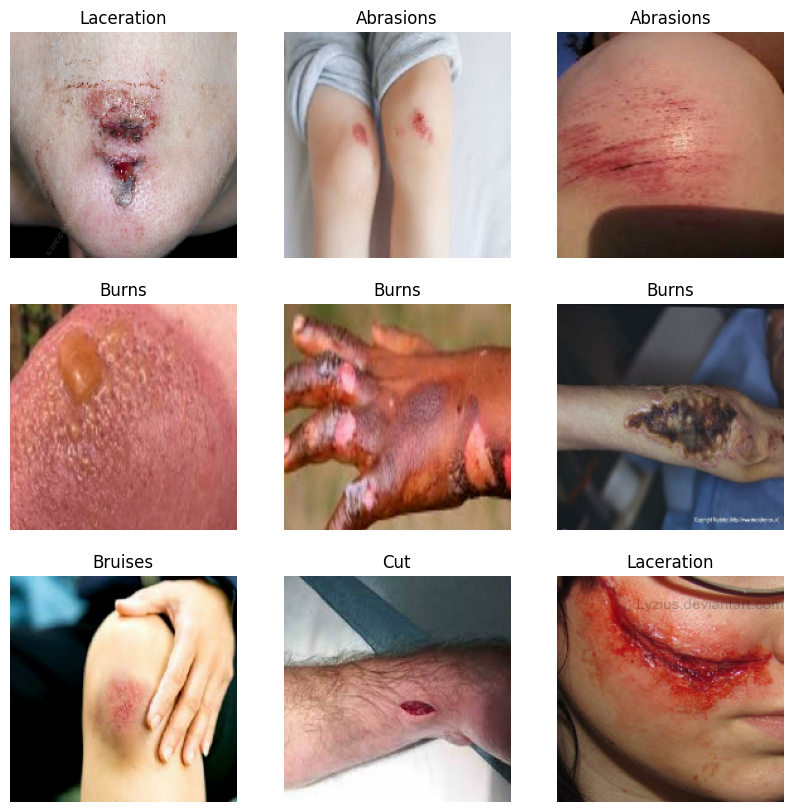

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_set:
  print(f"IMAGE BATCH SHAPE: {image_batch} <-> LABELS BATCH SHAPE: {labels_batch}")

IMAGE BATCH SHAPE: [[[[154.         83.         61.       ]
   [154.         82.         60.       ]
   [154.61111    79.611115   58.61111  ]
   ...
   [133.8333      7.891985   18.722221 ]
   [130.23146     5.166687   15.722222 ]
   [131.4105      8.243839   17.96606  ]]

  [[155.         83.         61.       ]
   [154.         82.         60.       ]
   [154.61111    79.611115   58.61111  ]
   ...
   [121.74076     6.213003   13.444479 ]
   [120.888855    7.8333335  14.       ]
   [118.06481     6.3981423  12.564809 ]]

  [[157.         82.         59.       ]
   [156.         81.         58.       ]
   [157.37346    79.37346    57.373455 ]
   ...
   [110.44444     5.6821446   9.444477 ]
   [113.3148      9.490772   12.935196 ]
   [107.780846    5.947512    8.558622 ]]

  ...

  [[178.        173.        154.       ]
   [177.        172.        153.       ]
   [174.61111   169.61111   150.61111  ]
   ...
   [109.610535   50.943665   49.165955 ]
   [ 87.73157    12.731565   16.731565

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
num_classes = len(class_names)

vision_network = Sequential([
    layers.Rescaling(1/.255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

vision_network.compile(optimizer="adam",
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

c:\Users\zayaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
vision_network.summary()

NameError: name 'model' is not defined

In [ ]:
EPOCHS = 50

history = vision_network.fit(
    train_set,
    validation_data=validation_set,
    epochs=EPOCHS
)

In [ ]:
accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
validation_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, validation_accuracy, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, validation_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()